# Graph Neural Networks for Solving Combinatorial Optimization Problems

<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/00_GNN_Definition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome! https://arxiv.org/abs/2107.01188

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7060d45f-6c2b-093c-2256-ea38603ee946)


During this notebook we will be using:
* JAX: a numerical computation library for Python, supports automatic differentiation and many other cool things
* Flax: machine learning library for Python built on top of JAX; Flax is very fexible and provides all the tools we need to implement the paper
* PyQUBO: a library for building quadratic unconstrained binary optimization (QUBO) models; this paper is all about QUBOs, and PyQUBO lets us write them in a straightforward way

Also, during the notebook you will see some comments on the cells to export code. This is because we use nbdev to create a package from this notebook. This will allow us to reuse all the code from this on the next ones!

In [ ]:
!pip install -q flax pyqubo

In [ ]:
# | default_exp core

In [ ]:
# | export
import jax
import jax.numpy as jnp
import numpy as np
import networkx as nx  # for making graphs
import optax  # for optimizing GNN with Adam

from flax import linen as nn  # for defining the GNN
from flax.training import train_state  # utility for training
from pyqubo import Array  # for defining the QUBO
from tqdm.notebook import trange, tqdm  # visualizing notebook progress

## QUBO Background

Now that we have installed and imported the libraries we need, let's dicuss QUBO formulations. 

QUBOs are a specific way to encode optimization problems. You have binary variables $x_{i} \in \{0, 1\}$ and write a Hamiltonian:

$$
H = \sum_{i=1}^{N} \sum_{j=i+1}^{N} b_{i,j}x_{i}x_{j} \sum_{i=1}^{N} a_{i} x_{i} + c
$$

Then, you give your Hamiltonian to a QUBO solver and (hopefully) the solver outputs a solution that minimizes $H$. Generally, the output from the solver is decoded and mapped back to a combinatorial optimization problem that is useful in the real-world. I recommend reading [Ising formulations of many NP problems
](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full) if you are interested more in the topic. Many, many problems can be encoded as QUBOs.

There is also another convenient way of writing QUBO problems using matrices. Let $Q$ be the matrix describe the QUBO coefficients, then:

$$
H = x^\intercal Q x
$$

They are equivalent, but for this specific case the matrix version is the one used in the paper. This makes sense for the implementation and given that the authors also want to reach the Deep Learning community that is familiar with linear algebra.

Two combinatorial optimization problems appear in the paper. The first one is the Max Cut problem. In the Max-Cut problem, you are given an undirected graph and a set of vertices. Your goal is to divide the vertices into two sets such that the number of edges connecting vertices in different sets is maximized. The Max-Cut problem has attracted a lot of interested from the research community (e.g. quantum computing), hence it is not surprising the authors chose it.

The QUBO formulation for the Max-Cut given a weighted-graph $G = (V, E)$ is:

$$
H = \sum_{(u, v) \in E} W_{u, v} (x_{u} - x_{v})^{2}
$$

The hamiltonian $H$ encodes the cost of the cut. If $x_{u} = 0$, then the vertex $u$ is in the first set. Analogously, if $x_{u} = 1$ then $u$ is in the other set. Notice that $(x_{u} - x_{v})^{2}$ evaluates to $1$ if and only if the vertices are in different sets. There are two details worth noticing in our implementation: we assume the ede weights $W_{u, v}$ are all one; and we feed $-H$ to our solver, because the solver finds a minimum (not a maximum).

The second optimization problem is the Maximum Independent Set (MIS). In the MIS, you are given a graph $G = (V, E)$ and your goal is to find a set of vertices such that no two vertices in the set are connected by an edge. This set is called an independent set. You want to find the independent set with the maximum number of vertices.

The QUBO formulation for the MIS is:

$$
H = \sum_{v \in V} x_{v} - P \sum_{(u, v) \in E} x_{u}x_{v}
$$

Because QUBOs don't have constraints, P is a penalty we added to the formulation such that the MIS solution is valid. We set $P = 2$ as in the paper.

Now that we discussed the formulations, let's implement them using PyQUBO. We have three functions: one for the Max-Cut formulation; one for the MIS formulation; and one for obtaining the Q matrix defined earlier.

In [ ]:
# | export
def create_max_cut_model(graph):
    N = graph.number_of_nodes()
    X = Array.create("X", shape=(N,), vartype="BINARY")

    hamiltonian = 0
    for u, v in graph.edges:
        hamiltonian -= (X[u] - X[v]) ** 2

    return hamiltonian.compile()


def create_mis_model(graph, penalty=2):
    N = graph.number_of_nodes()
    X = Array.create("X", shape=(N,), vartype="BINARY")

    hamiltonian = -sum(X)
    for u, v in graph.edges:
        hamiltonian += penalty * (X[u] * X[v])

    return hamiltonian.compile()


def create_Q_matrix(graph, is_max_cut=True):
    if is_max_cut:
        model = create_max_cut_model(graph)
    else:
        model = create_mis_model(graph)

    N = graph.number_of_nodes()
    extract_val = lambda x: int(x[2:-1])
    Q_matrix = np.zeros((N, N))

    qubo_dict, _ = model.to_qubo()

    for (a, b), quv in qubo_dict.items():
        u = min(extract_val(a), extract_val(b))
        v = max(extract_val(a), extract_val(b))
        Q_matrix[u, v] = quv

    return jnp.array(Q_matrix)

The two functions below implement a cost inspired by the hamiltonian using the QUBO matrix discussed earlier:

$$
H = x^\intercal Q x
$$

Notice that in the paper, as we will discussed later, we transition to a relaxed version of the Hamiltonian cost:

$$
\mathcal{L}_{QUBO} = p_{\Theta}^\intercal Q p_{\Theta} 
$$

Where $p_{\Theta}$ is a vector of probabilities. Instead of assigning 0 or 1 to the variables, the authors chose a continuous version which makes sense for training the GNN.

In [ ]:
# | export
def qubo_approx_cost(probs, Q):
    cost = jnp.sum(jnp.matmul(jnp.matmul(jnp.transpose(probs), Q), probs))
    return cost

In [ ]:
# | export
def compute_metrics(*, probs, q_matrix):
    energy = qubo_approx_cost(probs=probs, Q=q_matrix)
    metrics = {
        "energy": energy,
    }
    return metrics

## The Graph Convolution

We enter now the Neural Network section of the paper where we defined the architecture of the Graph Neural Network.

The core idea is using message passing. Each vertex $i$ in the graph contains a node feature vector $\textbf{x}_{i}$. The Graph Convolution learns to aggregate the messages of the vertex and its neighbours using $W_{1}$ and $W_{2}$:

$$
\textbf{x}_{i}^{\prime} = W_{1} \textbf{x}_{i} + W_{2} \sum_{j \in \mathcal{N}_{i}} e_{j, i} \textbf{x}_{j}
$$


We implement the Graph Convolution below using Flax + JAX. To calcualte $\sum_{j \in \mathcal{N}_{i}} e_{j, i} x_{j}$, we use the adjacency matrix of the graph. Notice that our implementation is focused on smaller graphs, hence we did not use sparse matrices (which is what powers the original paper).

In [ ]:
# | export
class GraphConvLayer(nn.Module):
    c_out: int  # Output feature size

    @nn.compact
    def __call__(self, node_feats, adj_matrix):
        node_feats_w1 = nn.Dense(features=self.c_out, use_bias=False)(node_feats)
        node_feats_w2 = jax.lax.batch_matmul(adj_matrix, node_feats)
        node_feats_w2 = nn.Dense(features=self.c_out)(node_feats_w2)
        return node_feats_w1 + node_feats_w2

## Unsupervised Learning and the Graph Neural Network 


With the Graph Convolution in hands, we can talk about the GNN architecture and its goals.

The idea proposed is to apply unsupervised learning to learn the node labels of the optimal solution just by using $\mathcal{L}_{QUBO}$. Let's say that the optimal solution is:

$$
x^\intercal  = \begin{bmatrix} 1, 0, 1, 0, 1 \end{bmatrix}
$$

Then, our neural network is trying to predict probabiltiies that the label is 0 or 1. So $p_{\Theta}$ would look something like this:

$$
p_{\Theta}^\intercal  = \begin{bmatrix} 0.9, 0.05, 0.87, 0.13, 0.99 \end{bmatrix}
$$

$\mathcal{L}_{QUBO}$ would give us an approximate cost of the QUBO (as if $p_{\Theta}$ were a superposition of many $x$). So overall, this is a pretty clever idea.

To find $p_{\Theta}$, they propose the following architecture for the GNN:
* Initialize the feature vectors $\textbf{x}_{i}$ for each vertex at random
* $k$ layers consisting of:
    * Applying the Graph Convolution
    * Applying an activation function which in the case is ReLU
    * Applying Dropout regularization to reduce overfitting

On the last of the $k$ layers, no ReLU or Regularization is applied. Instead, a Softmax to predict the probabilities takes place.

For the paper, the authors use $k = 2$ or $k = 3$ layers. For our Flax implementation. we use $k = 2$.

In [ ]:
# | export
class CombGNN(nn.Module):
    hidden_size: int
    num_classes: int
    dropout_frac: float

    @nn.compact
    def __call__(self, node_feats, adj_matrix, train=False):
        # First convolution
        h = GraphConvLayer(c_out=self.hidden_size)(
            node_feats=node_feats, adj_matrix=adj_matrix
        )
        h = nn.relu(h)
        h = nn.Dropout(rate=self.dropout_frac, deterministic=not train)(h)
        # Second convolution
        h = GraphConvLayer(c_out=self.num_classes)(node_feats=h, adj_matrix=adj_matrix)
        probs = nn.sigmoid(h)

        return probs

## Training neural networks with Flax

Now that we defined our architecture, it is time to write code to train the neural network!

Flax provides a TrainState dataclass that is very convenient to keep track of the paramters. Hence the code below does:
* Initiates the parameters for GNNComb using random values
* Assigns the Adam optimizer with the given learning rate (using optax, the optimizer for JAX)
* Returns a TrainState keeping track of our net, the current parameters, and all other hyperparameters we chose

In [ ]:
# | export
def create_train_state(
    n_vertices, embedding_size, hidden_size, rng, learning_rate, dropout_frac=0.0
):
    gnn = CombGNN(hidden_size=hidden_size, num_classes=1, dropout_frac=dropout_frac)
    dropout_rng = jax.random.PRNGKey(0)
    params = gnn.init(
        rngs={"params": rng, "dropout": dropout_rng},
        node_feats=jnp.ones([n_vertices, embedding_size]),
        adj_matrix=jnp.ones([n_vertices, n_vertices]),
        train=True,
    )["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=gnn.apply, params=params, tx=tx)

After we have our convenient TrainState class, we are going to perform training steps on them. One of the true magics of JAX is it just-in-time compilation. We apply the `@jax.jit` decorator to compile the code and make things super fast!

To train the neural network, we:
* Evaluate the GNN using the current parameters
* Calcualte the cost $\mathcal{L}_{QUBO}$
* Calcualte the gradients using JAX, which does all the backpropagation for us
* Let the optimizer handle the gradients and update the parameters

In [ ]:
# | export
@jax.jit
def train_step(state, node_embeddings, adj_matrix, q_matrix, dropout_rng):
    """Train for a single step."""

    def cost_fn(params):
        probs = state.apply_fn(
            {"params": params},
            node_embeddings,
            adj_matrix,
            rngs={"dropout": dropout_rng},
            train=True,
        )
        cost = qubo_approx_cost(probs=probs, Q=q_matrix)
        return cost, probs

    grad_fn = jax.grad(cost_fn, has_aux=True)
    grads, probs = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(probs=probs, q_matrix=q_matrix)
    return state, metrics

Last but not least on our training steps, is an utility method to recover the classifications. We are not interested in probabilities at the end. We want zeroes or ones!

In [ ]:
# | export
def get_classification(apply_fn, params, node_embeddings, adj_matrix):
    pred_probs = apply_fn({"params": params}, node_embeddings, adj_matrix)
    classification = jnp.where(pred_probs >= 0.5, 1, 0)
    return np.ravel(classification)

# Max-Cut On Example Graph

After all this introduction, it is time to check if our implementation works, right? We will start with the Max-Cut case.

We check our implementation against the small example present in the paper. So let's first define and visualize our graph.

In [ ]:
edgelist = [(0, 1), (1, 2), (2, 3), (3, 0), (1, 4), (2, 4)]
G = nx.from_edgelist(edgelist)

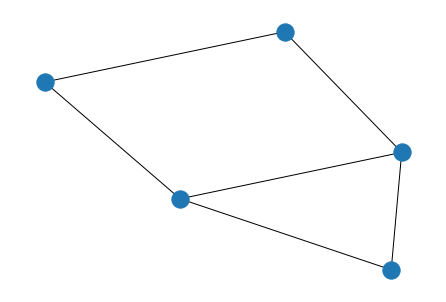

In [ ]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023))

Alright, our graph looks ready. Time to calculate two very important matrices for our training steps: the adjacency matrix $A$ and the QUBO matrix $Q$. $A$ is used in the graph convolutions and $Q$ is used for the cost. We take a peek at $A$ and $Q$ to check if they are correct

In [ ]:
A = jnp.array(nx.to_numpy_array(G))

In [ ]:
A

DeviceArray([[0., 1., 0., 1., 0.],
             [1., 0., 1., 0., 1.],
             [0., 1., 0., 1., 1.],
             [1., 0., 1., 0., 0.],
             [0., 1., 1., 0., 0.]], dtype=float32)

In [ ]:
Q = create_Q_matrix(G)

In [ ]:
Q

DeviceArray([[-2.,  2.,  0.,  2.,  0.],
             [ 0., -3.,  2.,  0.,  2.],
             [ 0.,  0., -3.,  2.,  2.],
             [ 0.,  0.,  0., -2.,  0.],
             [ 0.,  0.,  0.,  0., -2.]], dtype=float32)

The matrices look right. Time to train the neural network! The code:
* Creates the random number keys we need for initializing the network, embeddings, and training
* Defines our learning rate, size of node featurs, and size of the hidden features
* Trains the network for 500 epochs

note: JAX has a very particular way of working with random numbers; if you are new to JAX, pay attention to that

In [ ]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.005

In [ ]:
embedding_d0 = 5
embedding_d1 = embedding_d0 // 2

In [ ]:
state = create_train_state(
    G.number_of_nodes(), embedding_d0, embedding_d1, init_rng, learning_rate
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
node_embeddings

DeviceArray([[0.90081596, 0.38583064, 0.02542734, 0.7263125 , 0.77239466],
             [0.13210392, 0.2291317 , 0.15860796, 0.39851677, 0.9010197 ],
             [0.5372865 , 0.6941434 , 0.948866  , 0.5196214 , 0.97492456],
             [0.13318086, 0.49488008, 0.6443068 , 0.95046246, 0.5960568 ],
             [0.19223976, 0.44076335, 0.9235079 , 0.26473606, 0.49318063]],            dtype=float32)

In [ ]:
num_epochs = 500

In [ ]:
for epoch in trange(1, num_epochs + 1):
    rng, dropout_rng = jax.random.split(rng)
    state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )

    if epoch % 25 == 0:
        print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

  0%|          | 0/500 [00:00<?, ?it/s]

train epoch: 25, cost: -0.34
train epoch: 50, cost: -2.10
train epoch: 75, cost: -3.84
train epoch: 100, cost: -4.42
train epoch: 125, cost: -4.66
train epoch: 150, cost: -4.78
train epoch: 175, cost: -4.84
train epoch: 200, cost: -4.88
train epoch: 225, cost: -4.91
train epoch: 250, cost: -4.93
train epoch: 275, cost: -4.94
train epoch: 300, cost: -4.95
train epoch: 325, cost: -4.96
train epoch: 350, cost: -4.96
train epoch: 375, cost: -4.97
train epoch: 400, cost: -4.97
train epoch: 425, cost: -4.97
train epoch: 450, cost: -4.98
train epoch: 475, cost: -4.98
train epoch: 500, cost: -4.98


After finding the optimal parameters, let's examine the solution the network found:

In [ ]:
state.apply_fn({"params": state.params}, node_embeddings, A, train=True)

DeviceArray([[9.9998617e-01],
             [2.1988944e-04],
             [9.9997127e-01],
             [2.0501104e-03],
             [9.9555635e-01]], dtype=float32)

Probabilities are not very useful, so let's convert them to zeroes and ones and visualize:

In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

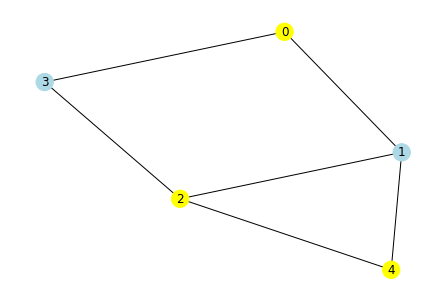

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)

The GNN found the optimal solution to the problem! The Max-Cut of the graph is 5 because of the edges $\{ (0, 1), (0, 3), (2, 1), (2, 3), (4, 1)\}$. Hence the code worked!

# Maximum Independet Set on Example Graph

In [ ]:
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G, is_max_cut=False)

In [ ]:
Q

DeviceArray([[-1.,  2.,  0.,  2.,  0.],
             [ 0., -1.,  2.,  0.,  2.],
             [ 0.,  0., -1.,  2.,  2.],
             [ 0.,  0.,  0., -1.,  0.],
             [ 0.,  0.,  0.,  0., -1.]], dtype=float32)

In [ ]:
rng = jax.random.PRNGKey(666)  # yeah I know
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.01

In [ ]:
embedding_d0 = 5
embedding_d1 = embedding_d0 // 2

In [ ]:
state = create_train_state(
    G.number_of_nodes(), embedding_d0, embedding_d1, init_rng, learning_rate
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
num_epochs = 500

In [ ]:
for epoch in trange(1, num_epochs + 1):
    state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )

    if epoch % 25 == 0:
        print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

  0%|          | 0/500 [00:00<?, ?it/s]

train epoch: 25, cost: -0.01
train epoch: 50, cost: -0.01
train epoch: 75, cost: -0.07
train epoch: 100, cost: -0.61
train epoch: 125, cost: -1.60
train epoch: 150, cost: -1.89
train epoch: 175, cost: -1.94
train epoch: 200, cost: -1.96
train epoch: 225, cost: -1.97
train epoch: 250, cost: -1.98
train epoch: 275, cost: -1.98
train epoch: 300, cost: -1.99
train epoch: 325, cost: -1.99
train epoch: 350, cost: -1.99
train epoch: 375, cost: -1.99
train epoch: 400, cost: -1.99
train epoch: 425, cost: -1.99
train epoch: 450, cost: -1.99
train epoch: 475, cost: -1.99
train epoch: 500, cost: -2.00


In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

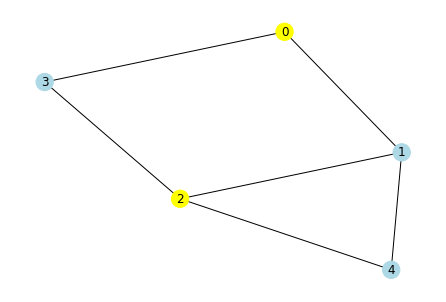

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)

# Max-Cut on Larger Graph


In [ ]:
G = nx.convert_node_labels_to_integers(
    nx.fast_gnp_random_graph(n=100, p=0.05, seed=2023)
)
A = jnp.array(nx.to_numpy_array(G))
Q = create_Q_matrix(G)

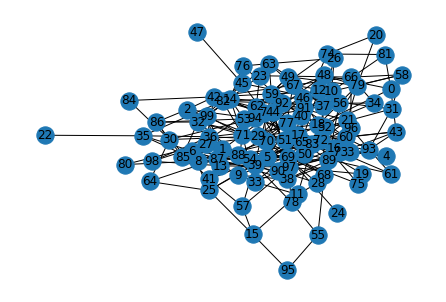

In [ ]:
nx.draw(G, pos=nx.spring_layout(G, seed=2023), with_labels=True)

In [ ]:
embedding_d0 = int(np.sqrt(G.number_of_nodes()))
embedding_d1 = embedding_d0 // 2

In [ ]:
rng = jax.random.PRNGKey(2023)
rng, init_rng = jax.random.split(rng)
rng, embed_rng = jax.random.split(rng)
state = create_train_state(
    G.number_of_nodes(),
    embedding_d0,
    embedding_d1,
    init_rng,
    learning_rate,
    dropout_frac=0.01,
)

In [ ]:
node_embeddings = jax.random.uniform(embed_rng, [G.number_of_nodes(), embedding_d0])

In [ ]:
num_epochs = 1000

In [ ]:
for epoch in trange(1, num_epochs + 1):
    rng, dropout_rng = jax.random.split(rng)
    state, metrics = train_step(
        state=state,
        node_embeddings=node_embeddings,
        adj_matrix=A,
        q_matrix=Q,
        dropout_rng=dropout_rng,
    )

    if epoch % 25 == 0:
        print("train epoch: %d, cost: %.2f" % (epoch, metrics["energy"]))

  0%|          | 0/1000 [00:00<?, ?it/s]

train epoch: 25, cost: -119.44
train epoch: 50, cost: -143.59
train epoch: 75, cost: -168.37
train epoch: 100, cost: -176.33
train epoch: 125, cost: -177.63
train epoch: 150, cost: -181.75
train epoch: 175, cost: -174.95
train epoch: 200, cost: -185.43
train epoch: 225, cost: -185.26
train epoch: 250, cost: -184.12
train epoch: 275, cost: -192.22
train epoch: 300, cost: -190.46
train epoch: 325, cost: -190.28
train epoch: 350, cost: -194.29
train epoch: 375, cost: -194.64
train epoch: 400, cost: -187.61
train epoch: 425, cost: -190.77
train epoch: 450, cost: -195.63
train epoch: 475, cost: -195.76
train epoch: 500, cost: -193.19
train epoch: 525, cost: -196.21
train epoch: 550, cost: -196.09
train epoch: 575, cost: -195.81
train epoch: 600, cost: -196.26
train epoch: 625, cost: -196.10
train epoch: 650, cost: -190.07
train epoch: 675, cost: -194.42
train epoch: 700, cost: -197.08
train epoch: 725, cost: -197.10
train epoch: 750, cost: -193.38
train epoch: 775, cost: -193.56
train epoch

In [ ]:
classification = get_classification(state.apply_fn, state.params, node_embeddings, A)

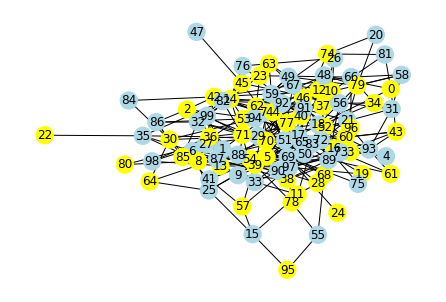

In [ ]:
nx.draw(
    G,
    pos=nx.spring_layout(G, seed=2023),
    node_color=["yellow" if c else "lightblue" for c in classification],
    with_labels=True,
)